---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

### Saverio Monaco
##### MAT: 2012264

# Homework 1 - Supervised Deep Learning
---
---

## Classification task

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

### Dataset

In [2]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np

# Deep Learning stuff
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Images display and plots
import matplotlib.pyplot as plt

# Other
import os


In [3]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [4]:
# If we have already the datafolder, do not download.
if(os.path.isdir('./classifier_data/FashionMNIST')):
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False,
                                                     transform = transforms.Compose([transforms.ToTensor()]) ) 
                                                      
else:
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
    

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True, num_workers=0)


In [ ]:
print('Number of instances in training dataset:', np.shape(train_dataset.data)[0])
print('Number of instances in testing dataset: ', np.shape(test_dataset.data)[0])

print('\nSize of the images:', np.shape(train_dataset.data[0].numpy()))


In [52]:
# Check for the ranges of value of the images
# There are two standards of representing grayscale images:
#  1. Each pixel ranges from 0 to 1
#  2. Each pixel ranges from 0 to 255

# The second one present more numerical instability

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in train_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min
        
print('TRAINING DATASET')
print(' range:', absmin.item(), '-', absmax.item())

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in test_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min

print('\nTEST DATASET')
print(' range:', absmin.item(), '-', absmax.item())

TRAINING DATASET
 range: 0.0 - 1.0

TEST DATASET
 range: 0.0 - 1.0


In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


In [36]:
def plot_mnistimg(dataset, sample, output = False, size = 3):
    '''
    Display the sample-th image from dataset (can be trainingset or testset) and its true
    label.
    Eventually display the predicted label in output.
    Size of the image can be changed changing size input parameter
    '''
    
    # Convert output (int) through the description of the images (str)
    description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
    
    image = np.array(dataset[sample][0])[0] # Image to display
    label = dataset[sample][1]              # Relative label (int)

    fig = plt.figure(figsize=(size,size))
    plt.imshow(image, cmap='Greys')
    
    print(f"Sample: {sample}")
    print(f"True Label: {description[label]}")
    
    if output:
        print(f"Prediction: {description[output]}")
    
    plt.axis("off")
    plt.show()
    

Sample: 10
True Label: T-shirt/top


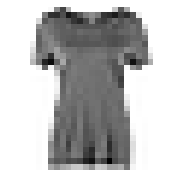

In [37]:
plot_mnistimg(train_dataset, 10)

### Building the Neural Network Structure

In [50]:
class CNNMnistNet(nn.Module):
    def __init__(self, Noutp, channels, activation = nn.ReLU(), dropout=0):
        """
        Ni - Input size  (INT)
        No - Output size (INT)
        Nhs - Hidden layers (LIST OF INTEGERS)
        """
        super(CNNMnistNet, self).__init__()
        
        self.activation = activation
        self.channels = channels
        
        if len(channels)!=2:
            print('Channels specified must be a list of two elements')
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels  = 1, # Because image is grayscale              
                out_channels = channels[0],            
                kernel_size  = 5,              
                stride       = 1,                   
                padding      = 2,                  
            ),                              
            activation,                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        # Dropout between two convolutions
        self.dropout = nn.Dropout(dropout)
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels  = channels[0], 
                out_channels = channels[1], 
                kernel_size  = 5, 
                stride       = 1, 
                padding      =2
            ),     
            activation,                      
            nn.MaxPool2d(2),                
        )
        
        # Fully connected layer to output 10 classes
        self.out = nn.Linear(channels[1] * 7 * 7, Noutp)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization
    
    def compute_accuracy(self, heatmap = False, verbose = False, examples=False):
        '''
        Compute accuracy of the model (%) from the testset
        heatmap  = True shows heatmap
        verbose  = True prints accuracy
        examples = True display some examples
        '''
        self.eval()
        # Input and true label
        x_test,y_test = next(iter(test_dataloader))
        # Prediction
        y_pred = self(x_test).argmax(dim=1)
        
        description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
        
        misclas = 0
        for i in range(len(y_pred) ):
            if y_pred[i] != y_test[i]:
                misclas = misclas + 1
        
        accuracy = 100*(len(y_pred) - misclas)/len(y_pred)
        
        if verbose:
            print('Accuracy:', accuracy, '%' )
            
        if heatmap:
            conf_mat = confusion_matrix(y_test, y_pred)
            fig, ax = plt.subplots(figsize=(10,8))
            plt.title('Heatmap')
            sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=description, yticklabels=description)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            
        if examples:
            indices = np.random.choice(np.arange(len(test_dataloader.dataset) ), size=5, replace=False)
            
            for index in indices:
                image = np.array(x_test[index][0])
                label = y_test[index]

                fig = plt.figure(figsize=(3,3))
                plt.imshow(image, cmap='Greys')
    
                print(f"\n\nTrue Label: {description[label]}")
                print(f"Prediction: {description[y_pred[index]]}")
    
                plt.axis("off")
                plt.show()
            
        return accuracy
    
    def fit(self, data, epochs, folds, torch_loss, printfreq, lr0, reg_term = 0,test=False):
        '''
        Function for training the Network
        data:       Dataloader
        epochs:     Number of epochs for the model to learn
        folds:      Folds in the k-fold cross validation
        torch_loss: Torch funcion for the loss
        printfreq:  Frequency of printing train loss and validation loss
        lr0:        Initial Learning rate
        reg_term:   Regularization term L2 penalty
        test =True: Computes accuracy on testset at each epoch, and 
                    displays learning curves
        '''
        train_loss_log = [] 
        test_loss_log = []
        val_loss_log = []
        
        # Define the optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr0, weight_decay= reg_term)
        
        for epoch in range(epochs):
            ### TRAIN
            train_loss = []
    
            self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
        
                kf = KFold(n_splits=folds)
                kf.get_n_splits(x_batch)
        
                loss = 0
                for train_index, val_index in kf.split(x_batch):
                    x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                    y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                    # Forward pass
                    out = self(x_batch_train)
        
                    # Compute loss
                    loss = loss + torch_loss(out, y_batch_train)/folds
                # Backpropagation
                self.zero_grad() # Clears gradient
                loss.backward()  # Computes the derivative of the loss

                # Update the weights
                optimizer.step() # Take a step based on the gradients

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

            # Save average train loss
            train_loss = np.mean(train_loss)
    
            if printfreq!=0 and epoch%printfreq == 0:
                print('#################')
                print(f'# EPOCH {epoch}')
                print('#################')
                print(f"AVERAGE TRAIN LOSS: {train_loss}")
                
            train_loss_log.append(train_loss)
            
            ### VALIDATION
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in data:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    kf = KFold(n_splits=folds)
                    kf.get_n_splits(x_batch)
        
                    loss = 0
                    for train_index, val_index in kf.split(x_batch):
                        x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                        y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                        # Forward pass
                        out = self(x_batch_val)

                        # Compute loss
                        loss = loss + torch_loss(out, y_batch_val)/folds
                
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
        
                # Save average validation loss
                val_loss = np.mean(val_loss)
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                    print('')
                val_loss_log.append(val_loss)
            
            if test:
                test_loss_log.append(self.compute_accuracy()) # Compute accuracy
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"TEST ACCURACY: {test_loss_log[-1]} %")
                    
        if test:
            fig=plt.figure(figsize = (7,8))
            ax1 = plt.subplot(211) # Loss on training
            ax2 = plt.subplot(212) # Accuracy on test
            
            xvalues = np.arange(0,epochs)
            
            ax1.set_title('Training Loss')
            ax1.plot(xvalues, train_loss_log, label='Training error')
            ax1.set_xlabel('epoch')
            
            ax2.set_title('Test Accuracy')
            ax2.set_ylabel('%')
            ax2.set_xlabel('epoch')
            ax2.set_ylim(-1,101)
            ax2.plot(xvalues, test_loss_log  , label='Test error', color='orange')
            
            plt.tight_layout()
            plt.show()
            
        return val_loss_log[-1]
    
    def plot_filters(self):
        '''Functions for visualizing the filters'''
        filter1 = model.conv1[0].weight.data.cpu().numpy()
        filter2 = model.conv2[0].weight.data.cpu().numpy()
        
        # FIRST CHANNEL #
        fig, ax = plt.subplots(1,self.channels[0], figsize=(16, 3))

        for i in range(self.channels[0]):
            ax[i].imshow( filter1[i, 0, :, :], cmap='Greys')
            ax[i].axis('off')
    
        fig.suptitle('Filters of first convolutional layer')
        plt.show()
        
        # SECOND CHANNEL #
        fig, ax = plt.subplots(self.channels[0], self.channels[1], figsize=(16, 7))

        for i in range(self.channels[0]):
            for j in range(self.channels[1]):
                ax[i,j].imshow( filter2[j, i, :,:], cmap='Greys')
                ax[i,j].axis('off')
        
        fig.suptitle('Filters of second convolutional layer')
        plt.show()
        
    def plot_activations(self):
        def get_activation(layer, input, output):
            global activation
            activation = self.activation(output)

        ex_dataloader =  DataLoader(test_dataset, batch_size = 1, shuffle=True, num_workers=0)
        
        ### Register hook  
        hook_handle = self.conv1.register_forward_hook(get_activation)

        ### Analyze activations
        self.eval()

        with torch.no_grad():
            for s_batch in ex_dataloader:
                # Move data to device
                x1 = s_batch[0].to(device)
                # Forward pass
                y1 = self(x1)
                z1 = activation

        ### Remove hook
        hook_handle.remove()

        act1 = z1.cpu().numpy()

        ## Plot activations
        fig, ax = plt.subplots(1, self.channels[0], figsize=(16,3))
        for i in range(self.channels[0]):
            ax[i].imshow( act1[0, i, :, :], cmap='Greys')
            ax[i].axis('off')

        fig.suptitle('Activation profile - first convolutional layer', fontsize=16)    
        plt.tight_layout()

        plt.show()   
        
        ### Register hook  
        hook_handle = self.conv2.register_forward_hook(get_activation)

        with torch.no_grad():
            for s_batch in ex_dataloader:
                # Move data to device
                x2 = s_batch[0].to(device)
                # Forward pass
                y2 = self(x2)
                z2 = activation

        ### Remove hook
        hook_handle.remove()

        act2 = z2.cpu().numpy()

        ## Plot activations
        fig, ax = plt.subplots(2, self.channels[0], figsize=(16,6))

        for i in range(self.channels[0]):
            ax[0, i].imshow( act2[0, i, :, :], cmap='Greys')
            ax[0, i].axis('off')
            ax[1, i].imshow( act2[0, i+self.channels[0], :, :], cmap='Greys')
            ax[1, i].axis('off')

        fig.suptitle('Activation profile - second convolutional layer', fontsize=16)    
        plt.tight_layout()

        plt.show()   
        
    

In [51]:
# Hyperparameters for the gridsearch:
grid_lrs = [1e-3]
grid_regs = [1e-4]
grid_channels = [[3,6]]
grid_dropouts = [.01]
grid_activations = [nn.ReLU()]
grid_losses = [nn.CrossEntropyLoss()]

best_train_loss = 1000000
best_val_loss   = 1000000

grid_epochs = 3

i = 0 # Loop variable, tells us at what configuration we currently are

for grid_lr in grid_lrs:
    for grid_loss in grid_losses:
        for grid_reg in grid_regs:
            for grid_channel in grid_channels:
                for grid_dropout in grid_dropouts:
                    for grid_activation in grid_activations:
                        # For every possible combination of hyperparameters...
                        grid_model = CNNMnistNet(10, grid_channel, activation = grid_activation, dropout=grid_dropout)
                        grid_val_loss = grid_model.fit(train_dataloader, grid_epochs, 3, grid_loss, 0, grid_lr, 
                                                       reg_term = grid_reg)
                
                        if grid_val_loss < best_val_loss:
                            best_val_loss = grid_val_loss
                    
                            # Save the best combination of the hyperparameters in a dictionary
                            # so we can inspect the best model later
                            best_config = {
                              "lr":            grid_lr,
                              "loss":          grid_loss,
                              "reg":           grid_reg,
                              "channels":      grid_channel,
                              "dropout":       grid_dropout,
                              "activation":    grid_activation}
                            
                            if True: # Set to False, too much useless information displayed
                                print('---------------------')
                                print('Configuration', i)
                                print(' Validation loss: ', grid_val_loss)
                                print(' Lr =           ', grid_lr)
                                print(' Loss =         ', grid_loss)
                                print(' Reg =          ', grid_reg)
                                print(' Channels =     ', grid_channel)
                                print(' dropout =      ', grid_dropout)
                                print(' activation =   ', grid_activation)
                                print('')
                
                        i = i + 1

---------------------
Configuration 0
 Validation loss:  0.41729075
 Lr =            0.001
 Loss =          CrossEntropyLoss()
 Reg =           0.0001
 Channels =      [3, 6]
 dropout =       0.01
 activation =    ReLU()



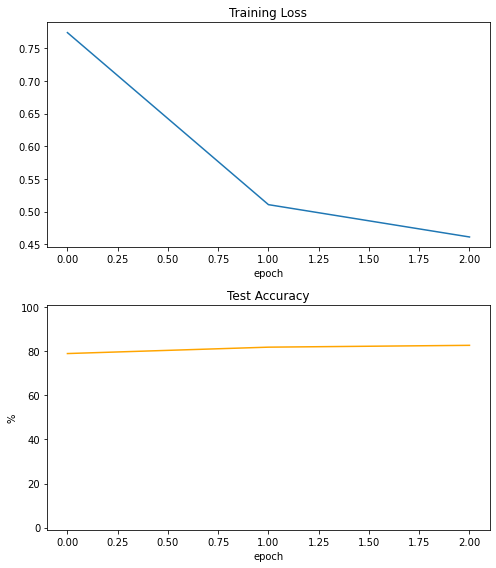

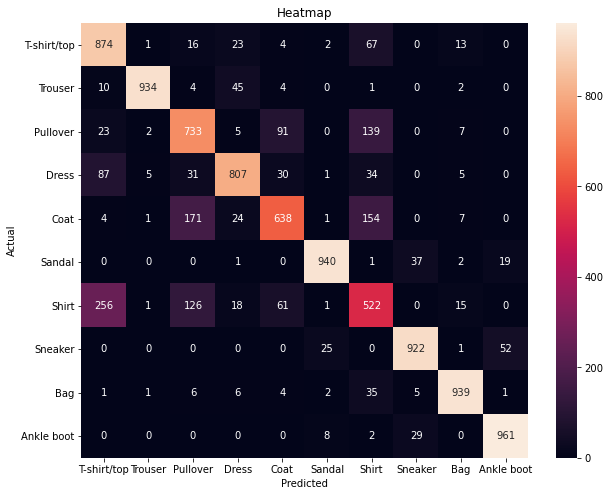

82.7

In [52]:
best_model = CNNMnistNet(10, best_config['channels'], activation = best_config['activation'], dropout=best_config['dropout'])
best_model.fit(train_dataloader, 3, 3, best_config['loss'], 0, best_config['lr'], reg_term = best_config['reg'], test=True)

best_model.compute_accuracy(heatmap=True)

### Filter visualization

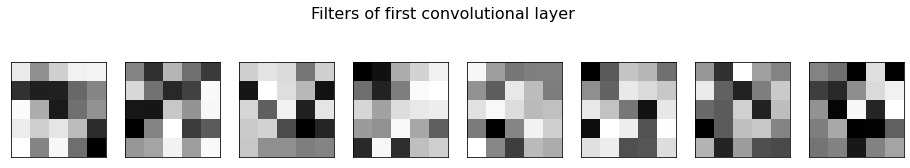

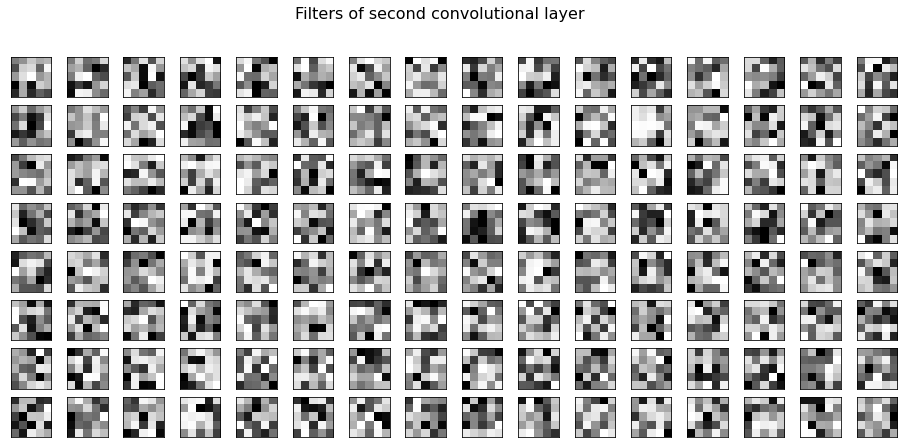

In [14]:
best_model.plot_filters()

### Activation layer

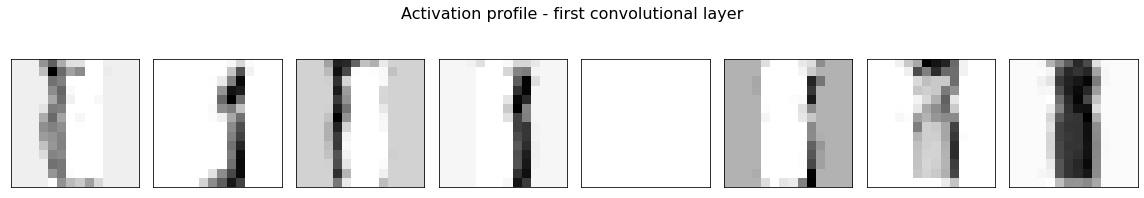

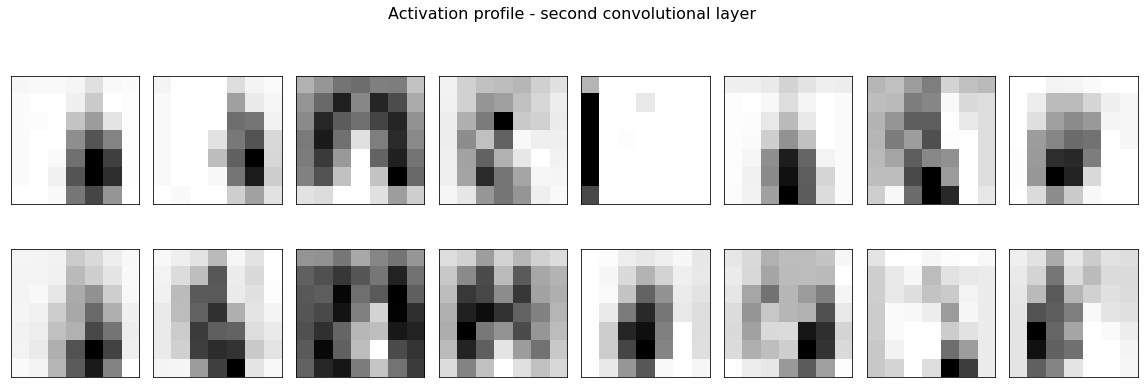

In [22]:
best_model.plot_activations()


### Data Augmentation

In [24]:
augmentation = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.RandomVerticalFlip(p=0.5),
                     transforms.RandomCrop(28,padding=2)])

In [30]:
# If we have already the datafolder, do not download.
if(os.path.isdir('./classifier_data/FashionMNIST')):
    aug_train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False,
                                                     transform = augmentation )
                                                      
    aug_test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False,
                                                     transform = augmentation ) 
                                                      
else:
    aug_train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True,
                                                     transform = augmentation )
                                                      
    aug_test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,
                                                     transform = augmentation )
    
aug_train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=0)
aug_test_dataloader = DataLoader(test_dataset, batch_size = 100, shuffle=True, num_workers=0)

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.43681976199150085
TEST ACCURACY: 87.67 %
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.30016493797302246
TEST ACCURACY: 88.42 %


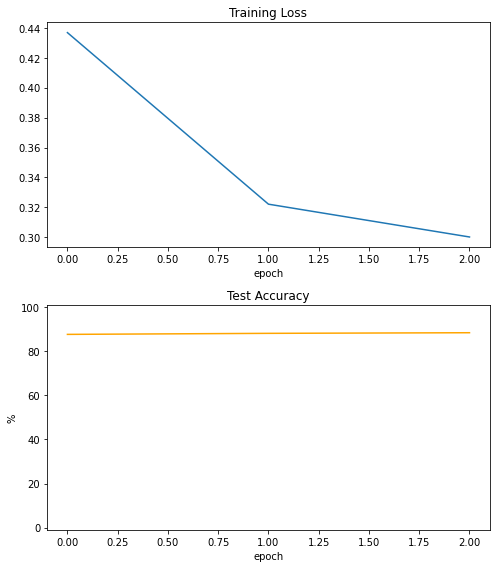

In [32]:
aug_model = CNNMnistNet(10, best_config['channels'], activation = best_config['activation'], dropout=best_config['dropout'])
aug_model.fit(aug_train_dataloader,3, 3, best_config['loss'], 0, best_config['lr'], reg_term = best_config['reg'], test=True)

best_model.compute_accuracy(heatmap=True)